# Оптимизация производства

Нам предстоит построить модель, которая предскажет коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. 

###### Данное исследование разделим на несколько этапов.

##### 1. Подготовка данных:
* [1.1. Загрузка библиотек, изучение файлов с данными, получение общей информации.](#section1)
* [1.2. Проверим, что эффективность обогащения рассчитана правильно.](#section2)
* [1.3. Проанализируем признаки, недоступные в тестовой выборке.](#section3)
* [1.4. Проведем предобработку данных.](#section4)


##### 2. Анализ данных:
* [2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.](#section5)
* [2.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.](#section6)
* [2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.
](#section7)


##### 3. Модель:
* [3.1. Напишем функцию для вычисления итоговой sMAPE.](#section8)
* [3.2. Извлекаем в отдельные переменные признаки.](#section9)
* [3.3. Масштабируем признаки.](section10)
* [3.4. Обучим разные модели и оценим их качество кросс-валидацией](section11)
* [3.5. Настроим гиперпараметры модели.](section12)
* [3.6. Получим предсказания модели на тестовой выборке.](section13)
* [3.7. Получим итоговый sMAPE.](section14)
* [3.8. Проверим модель на адекватность.](section15)


##### 4. Общий вывод:
* [4.1. Формулировка общего вывода.](#section16)


<a id='section1'></a>

# 1. Подготовка данных

### 1.1. Загрузка библиотек, изучение файлов с данными, получение общей информации.

#### Импортируем все необходимые библиотеки.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
import seaborn as sns

from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import RandomizedSearchCV

from sklearn.dummy import DummyRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import make_scorer

#### Прочитаем файл с данными.

In [2]:
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

#### Получим первые строки таблицы.

In [3]:
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [5]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


### Описание данных:
    
#### Технологический процесс
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate ** — ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

#### Параметры этапов
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

#### Наименование признаков

Этап:
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

Тип параметра:
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

#### Целевой признак:
* эффективность обогащения чернового концентрата `rougher.output.recovery`
* эффективность обогащения финального концентрата `final.output.recovery`

#### Изучим общую информацию таблицы.

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

*Рассмотрим полученную информацию подробнее. Всего в таблице 87 столбцов и 16860 строк. Присутствуют два типа данных: 86 - float и 1 - object. Количество значений в столбцах различается. Это говорит о том, что в данных присутствуют пропущенные значения.*

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

*Рассмотрим полученную информацию подробнее. Всего в таблице 53 столбца и 5856 строк. Присутствуют два типа данных: 52 - float и 1 - object. Количество значений в столбцах различается. Это говорит о том, что в данных присутствуют пропущенные значения.*

In [8]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

*Рассмотрим полученную информацию подробнее. Всего в таблице 87 столбцов и 22716 строк. Присутствуют два типа данных: 86 - float и 1 - object. Количество значений в столбцах различается. Это говорит о том, что в данных присутствуют пропущенные значения.*

#### Проверим данные на наличие дубликатов

In [9]:
df_train.duplicated().sum()

0

In [10]:
df_test.duplicated().sum()

0

In [11]:
df_full.duplicated().sum()

0

Дубликатов в данных не обнаружено.

#### Проверим данные на наличие пропусков

In [12]:
df_train.isnull().mean().sort_values(ascending = False).head(10)

rougher.output.recovery               0.152610
rougher.output.tail_ag                0.133452
rougher.output.tail_sol               0.133393
rougher.output.tail_au                0.133393
secondary_cleaner.output.tail_sol     0.117794
rougher.input.floatbank11_xanthate    0.112930
final.output.recovery                 0.090214
primary_cleaner.input.sulfate         0.077521
primary_cleaner.input.depressant      0.074852
rougher.calculation.au_pb_ratio       0.073665
dtype: float64

*Видим, что наибольшее кол-во пропусков содержат следующие признаки: `rougher.output.recovery` (15%), `rougher.output.tail_ag` (13%), `rougher.output.tail_sol` (13%) и `rougher.output.tail_au` также 13%.*

In [13]:
df_test.isnull().mean().sort_values(ascending = False).head(10)

rougher.input.floatbank11_xanthate          0.060280
primary_cleaner.input.sulfate               0.051571
primary_cleaner.input.depressant            0.048497
rougher.input.floatbank10_sulfate           0.043887
primary_cleaner.input.xanthate              0.028347
rougher.input.floatbank10_xanthate          0.021004
rougher.input.feed_sol                      0.011441
rougher.input.floatbank11_sulfate           0.009392
rougher.input.feed_rate                     0.006831
secondary_cleaner.state.floatbank3_a_air    0.005806
dtype: float64

*В данном датасете содержится не такое большое кол-во пропусков как в тренировочной выборке.*

In [14]:
df_full.isnull().mean().sort_values(ascending = False).head(10)

rougher.output.recovery               0.137304
rougher.output.tail_ag                0.120488
rougher.output.tail_sol               0.120444
rougher.output.tail_au                0.120444
rougher.input.floatbank11_xanthate    0.099357
secondary_cleaner.output.tail_sol     0.097508
final.output.recovery                 0.086415
rougher.calculation.au_pb_ratio       0.071624
primary_cleaner.input.sulfate         0.070831
primary_cleaner.input.depressant      0.068058
dtype: float64

*Видим, что наибольшее кол-во пропусков содержат следующие признаки: `rougher.output.recovery` (13%), `rougher.output.tail_ag` (12%), `rougher.output.tail_sol` (12%) и `rougher.output.tail_au` также 12%.*

<a id='section2'></a>

### 1.2. Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между нашими расчётами и значением признака. 

Эффективность обогащения рассчитывается по формуле:

Recovery = (C*(F-T))/(F*(C-T))*100

где:
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

#### Вычислим эффективность обогащения на копии обучающей выборке.

In [15]:
df_train_copy = df_train.copy()

In [16]:
C=df_train_copy['rougher.output.concentrate_au']
F=df_train_copy['rougher.input.feed_au']
T=df_train_copy['rougher.output.tail_au']

In [17]:
df_train_copy['train_recovery'] = (C*(F-T))/(F*(C-T))*100

#### Найдем MAE между нашими расчётами и значением признака rougher.output.recovery

Удалим пропущенные значения 

In [18]:
df_train_copy.dropna(inplace=True)

In [19]:
MAE = mean_absolute_error(df_train_copy['rougher.output.recovery'], df_train_copy['train_recovery'])
MAE

9.555596961987514e-15

*Средняя абсолютная ошибка очень мала, это значит, что эффективность обогащения рассчитана правильно.*

<a id='section3'></a>

### 1.3. Проанализируем признаки, недоступные в тестовой выборке.

In [20]:
result = list(set(df_train) - set(df_test))

In [21]:
print('Количество признаков недоступных в тестовой выборке:',len(result))
result

Количество признаков недоступных в тестовой выборке: 34


['secondary_cleaner.output.tail_ag',
 'rougher.output.recovery',
 'rougher.output.tail_sol',
 'final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'rougher.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'final.output.tail_pb',
 'primary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.output.tail_ag',
 'secondary_cleaner.output.tail_au',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'final.output.concentrate_sol',
 'rougher.calculation.au_pb_ratio',
 'final.output.recovery',
 'primary_cleaner.output.tail_au',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'final.output.tail_au',
 'rougher.output.tail_pb',
 'rougher.output.concentrate_pb',
 'rougher.output.tail_au',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'final.output.tail_ag',

*Всего в тестовой выборке отсутствуют 34 признака, в них входят целевые признаки: `final.output.recovery` и `rougher.output.recovery`. В основном недоступны параметры продукта(`output`) и расчётные характеристики(`calculation`). Данные параметры в тестовой выборке недоступны, т.к. замерялись и рассчитывались значительно позже. Все отсутствующие признаки относятся к типу данных float.*

<a id='section4'></a>

### 1.4. Проведем предобработку данных.

#### Изменим тип данных столбца `date` c object на float.

In [22]:
for df in df_full, df_test, df_train:
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

#### Создадим таблицу с целевыми признаками и датой измерения.

In [23]:
target= df_full.loc[:,['date', 'final.output.recovery', 'rougher.output.recovery']]
target

,date,final.output.recovery,rougher.output.recovery
0,2016-01-15 00:00:00,70.541216,87.107763
1,2016-01-15 01:00:00,69.266198,86.843261
2,2016-01-15 02:00:00,68.116445,86.842308
3,2016-01-15 03:00:00,68.347543,87.226430
4,2016-01-15 04:00:00,66.927016,86.688794
...,...,...,...
22711,2018-08-18 06:59:59,73.755150,89.574376
22712,2018-08-18 07:59:59,69.049291,87.724007
22713,2018-08-18 08:59:59,67.002189,88.890579
22714,2018-08-18 09:59:59,65.523246,89.858126


#### Удалим из исходных данных целевые признаки  `final.output.recovery` и `rougher.output.recovery`.

In [24]:
df_full=df_full.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1)

#### Заполним пропущенные значения предыдущими в исходных данных.

In [25]:
df_full = df_full.fillna(method='ffill') #pad

In [26]:
df_full.isnull().mean().sum()

0.0

Объединим таблицы с исходными данными и target

In [27]:
df_full = df_full.merge(target, on='date') 

In [28]:
df_full.isnull().mean()

date                                          0.000000
final.output.concentrate_ag                   0.000000
final.output.concentrate_pb                   0.000000
final.output.concentrate_sol                  0.000000
final.output.concentrate_au                   0.000000
                                                ...   
secondary_cleaner.state.floatbank5_b_level    0.000000
secondary_cleaner.state.floatbank6_a_air      0.000000
secondary_cleaner.state.floatbank6_a_level    0.000000
final.output.recovery                         0.086415
rougher.output.recovery                       0.137304
Length: 87, dtype: float64

#### Посчитаем эффективность обогащения для пропущенных значений.

In [29]:
C=df_full['rougher.output.concentrate_au']
F=df_full['rougher.input.feed_au']
T=df_full['rougher.output.tail_au']

df_full['rougher.output.recovery'] = df_full['rougher.output.recovery'].fillna((C*(F-T))/(F*(C-T))*100)

In [30]:
C=df_full['final.output.concentrate_au']
F=df_full['rougher.input.feed_au']
T=df_full['final.output.tail_au']

df_full['final.output.recovery'] = df_full['final.output.recovery'].fillna((C*(F-T))/(F*(C-T))*100)

In [31]:
df_full.isnull().mean()

date                                          0.000000
final.output.concentrate_ag                   0.000000
final.output.concentrate_pb                   0.000000
final.output.concentrate_sol                  0.000000
final.output.concentrate_au                   0.000000
                                                ...   
secondary_cleaner.state.floatbank5_b_level    0.000000
secondary_cleaner.state.floatbank6_a_air      0.000000
secondary_cleaner.state.floatbank6_a_level    0.000000
final.output.recovery                         0.067574
rougher.output.recovery                       0.066869
Length: 87, dtype: float64

#### Удалим строки с пропущенными значениями

In [32]:
df_full = df_full.dropna()

#### Создадим список по датам в тренировочной выборке и в тестовой

In [33]:
index_train=list(df_train['date'])

In [34]:
index_test=list(df_test['date'])

#### Выберем из исходной выборке только те строки которые соответствуют  дате в тренировочной и в тестовой выборке и сохраним в соответствующие переменные.

In [35]:
train= df_full.query('date in @index_train')

In [36]:
test= df_full.query('date in @index_test')

## ВЫВОД 
На данном этапе проекта мы изучили данные с параметрами добычи и очистки золота и золотосодержащей руды. Проверили данные на наличие пропусков и дубликатов. Обнаружили большое кол-во пропущенных значений. Пропуски возникли в результате того, что параметры замерялись и рассчитывались значительно позже. Проверили, правильно ли рассчитана эффективность обогащения. Провели предобработку данных, и заполнили пропущенные значения предыдущими значениями.

<a id='section5'></a>

# 2. Анализ данных

### 2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

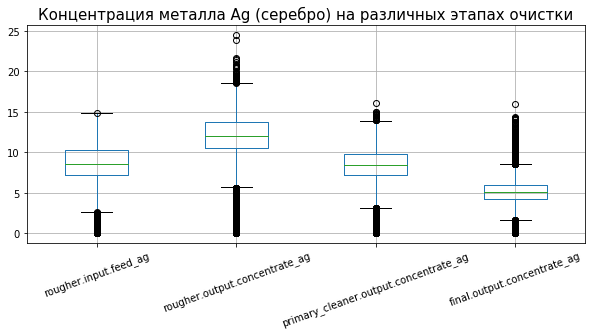

In [37]:
df_full.loc[:, ['rougher.input.feed_ag',
                'rougher.output.concentrate_ag', 
                'primary_cleaner.output.concentrate_ag', 
                'final.output.concentrate_ag']].boxplot(grid=True, figsize=(10, 4),  rot=20)
plt.title('Концентрация металла Ag (серебро) на различных этапах очистки', fontsize=15) 
plt.show()

*Концентрация металла Ag с каждым этапом очистки уменьшается. На финальном этапе концентрация серебра ниже, чем на первом этапе очистки. Максимальную концентрацию металла Ag мы наблюдаем на втором этапе очистки. Делаем вывод, что в данных присутствуют выбросы.*

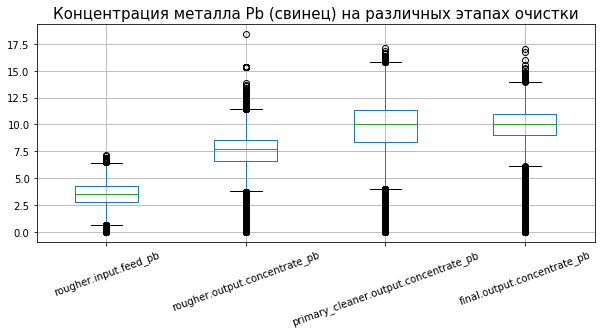

In [38]:
df_full.loc[:, ['rougher.input.feed_pb',
                'rougher.output.concentrate_pb', 
                'primary_cleaner.output.concentrate_pb', 
                'final.output.concentrate_pb']].boxplot(grid=True, figsize=(10, 4),  rot=20)
plt.title('Концентрация металла Pb (свинец) на различных этапах очистки', fontsize=15) 

plt.show()

*Концентрация свинца с каждым этапом очистки увеличивается, но на финальном этапе показатель медианы такой же, как и на предыдущем этапе, однако уменьшается разброс значений. Делаем вывод, что в данных присутствуют выбросы.*


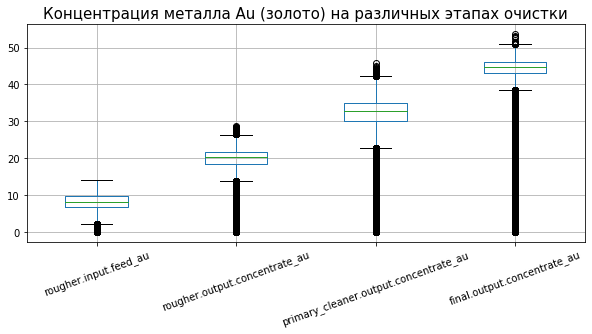

In [39]:
df_full.loc[:, ['rougher.input.feed_au',
                'rougher.output.concentrate_au', 
                'primary_cleaner.output.concentrate_au', 
                'final.output.concentrate_au']].boxplot(grid=True, figsize=(10, 4),  rot=20)
plt.title('Концентрация металла Au (золото) на различных этапах очистки', fontsize=15) 

plt.show()

*Концентрация золота с каждым этапом очистки увеличивается, что соответствует технологическому процессу очистки золота и золотосодержащей руды. По длинным хвостам графика мы можем сделать вывод о том, что в данных присутствуют выбросы.*

<a id='section6'></a>

### 2.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

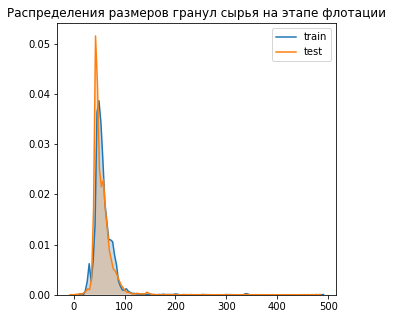

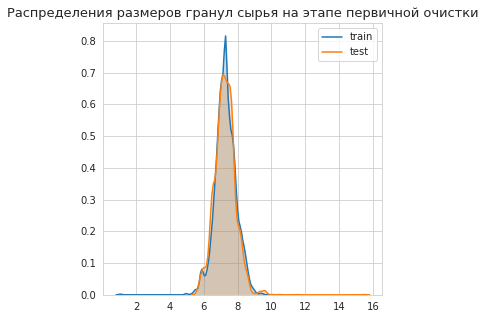

In [40]:
#График распределения размеров гранул сырья на этапе флотации
plt.figure(figsize=(5, 5))
sns.kdeplot(df_train['rougher.input.feed_size'], shade=True, label='train')
sns.kdeplot(df_test['rougher.input.feed_size'], shade=True, label='test')
sns.set_style("whitegrid")
plt.title('Распределения размеров гранул сырья на этапе флотации')
plt.show()

#График распределения размеров гранул сырья на этапе первичной очистки
plt.figure(figsize=(5, 5))
sns.kdeplot(df_train['primary_cleaner.input.feed_size'], shade=True, label='train')
sns.kdeplot(df_test['primary_cleaner.input.feed_size'], shade=True, label='test')
sns.set_style("whitegrid")
plt.title('Распределения размеров гранул сырья на этапе первичной очистки', fontsize=13)
plt.show()

*Распределения размеров гранул сырья на обучающей и тестовой выборках не сильно отличаются друг от друга. Соответственно, это не сильно повлияет на оценку модели.*

<a id='section7'></a>

### 2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

#### Суммируем концентрацию всех веществ на разных стадиях.

In [41]:
df_full['sum_raw_material']=df_full.loc[:, ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au']].sum(axis=1)
df_full['sum_rough']=df_full.loc[:, ['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au']].sum(axis=1)
df_full['sum_final']=df_full.loc[:, ['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au']].sum(axis=1)

#### Построим график распределения

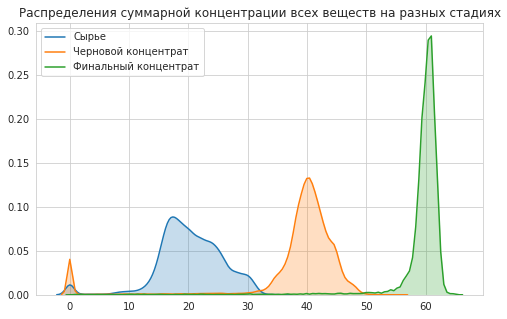

In [42]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df_full['sum_raw_material'], shade=True, label='Сырье')
sns.kdeplot(df_full['sum_rough'], shade=True, label='Черновой концентрат')
sns.kdeplot(df_full['sum_final'], shade=True, label='Финальный концентрат')
sns.set_style("whitegrid")
plt.title('Распределения суммарной концентрации всех веществ на разных стадиях')
plt.show()

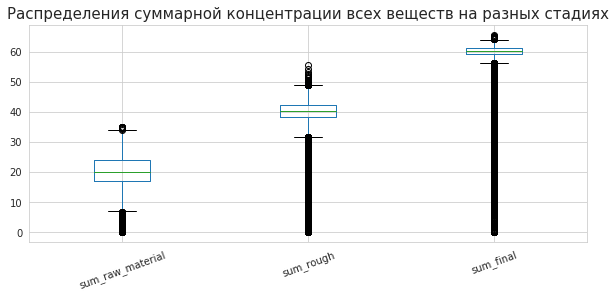

In [43]:
df_full.loc[:, ['sum_raw_material', 'sum_rough', 'sum_final']].boxplot(grid=True, figsize=(10, 4),  rot=20)
plt.title('Распределения суммарной концентрации всех веществ на разных стадиях', fontsize=15)
plt.show()

*По графику видим, что в данных на всех стадиях очистки присутствуют выбросы. Их стоит удалить, чтобы они негативно не повлияли на работу будущей модели.*


Сохраним номера индексов по дате сторк, у которых суммарный концентрат не равен 0

In [44]:
index_no_zero=list(df_full.query('sum_raw_material > 1 & sum_rough > 1 & sum_final > 1')['date'])

#### Оставим в данных только те значения,  у которых  суммарный концентрат всех веществ больше 1.

In [45]:
df_full=df_full.query('sum_raw_material > 1 & sum_rough > 1 & sum_final > 1')

In [46]:
df_full.loc[:, ['sum_raw_material', 'sum_rough', 'sum_final']].describe()

,sum_raw_material,sum_rough,sum_final
count,19896.000000,19896.000000,19896.000000
mean,20.706820,40.011351,59.295177
std,4.674776,4.774557,5.153140
min,1.130990,1.137053,1.084495
25%,17.227756,38.482079,59.225348
50%,20.210281,40.389883,60.262375
75%,23.990464,42.490261,61.065929
max,35.071987,55.568687,65.575259


*Мы видим, что минимальный показатель суммарной концентрации всех металлов выше 1, аномальных значений не наблюдается. Такой подход позволил уменьшить разброс данных.*


#### Оставим в обучающей и тестовой выборке только те данные, которые мы оставили в исходных данных.

In [47]:
index_date=list(df_full['date'])

In [48]:
train = train.query('date in @index_date')

In [49]:
test = test.query('date in @index_date')

## ВЫВОД 
На данном этапе проекта мы посмотрели, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Сравнили распределения размеров гранул сырья на обучающей и тестовой выборках. Исследовали суммарную концентрацию всех веществ на разных стадиях.

<a id='section8'></a>

# 3. Модель

### 3.1. Напишем функцию для вычисления итоговой sMAPE.

In [50]:
def smape(target, predictions):
    mae = mean_absolute_error(target, predictions)
    sum_abs = 100 * 2 / (abs(target) + abs(predictions))
    smape=mae*sum_abs  
    return smape.mean()

In [51]:
def final_smape(smape_rougher, smape_final):
    smape_final = 0.25 * smape_rougher + 0.75 * smape_final
    return smape_final

<a id='section9'></a>

### 3.2. Извлекаем в отдельные переменные признаки.

In [52]:
features_train = train.drop(['final.output.recovery', 'rougher.output.recovery', 'date'], axis=1)
target_rougher_train = train['rougher.output.recovery']
target_final_train = train['final.output.recovery']

features_test = test.drop(['final.output.recovery', 'rougher.output.recovery', 'date'], axis=1)
target_rougher_test = test['rougher.output.recovery']
target_final_test = test['final.output.recovery']

<a id='section10'></a>

### 3.3. Масштабируем признаки

#### Для масштабирования зафиксируем численные признаки.

In [53]:
numeric = features_train.columns

#### Создадим объект структуры StandardScaler() и настроим его на обучающих данных.

In [54]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

#### Сохраним преобразованные выборки.

In [55]:
pd.options.mode.chained_assignment = None #отключение предупреждения

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

<a id='section11'></a>

### 3.4. Обучим разные модели и оценим их качество кросс-валидацией

In [56]:
models = []

models.append(('model_LR', LinearRegression()))
models.append(('model_DTR', DecisionTreeRegressor(random_state=12345)))
models.append(('model_RFR', RandomForestRegressor(random_state=12345)))

data = []
final_scores = []
rougher_scores = []
names = []
for name, model in models:
    
    scorer = make_scorer(smape, greater_is_better=False)
    
    model.fit(features_train, target_rougher_train)
    rougher_score = cross_val_score(model, features_train, target_rougher_train, cv = 5, scoring=scorer).mean()
    
    model.fit(features_train, target_final_train)
    final_score = cross_val_score(model, features_train, target_final_train, cv = 5, scoring=scorer).mean()
    
    rougher_scores.append(rougher_score)
    final_scores.append(final_score)
    names.append(name)
    data.append([name, rougher_score, final_score])
    
#сохраним результаты в отдельную таблицу
mod = pd.DataFrame(data, columns=['model', 'rougher_score', 'final_score'])
mod

,model,rougher_score,final_score
0,model_LR,-172.504367,-16.950210
1,model_DTR,-21.726356,-6.202397
2,model_RFR,-23.627937,-4.652818


*Наилучший результат показывает модель случайного леса. Улучшим модель RandomForestRegressor, путем подбора гиперпараметров.*

<a id='section12'></a>

### 3.5. Настроим гиперпараметры модели

Для этого нам необходимо перебрать разные значения по методу RandomizedSearchCV.

In [57]:
model_RFR =  RandomForestRegressor(random_state=12345)
#Создаем сетку гиперпараметров

for v in target_rougher_train, target_final_train:
    param_grid = { 
        'max_features' : ["auto", "sqrt", "log2"],
        'min_samples_split' : np.linspace(0.1, 1.0, 10),
        'max_depth' : range (1,15)}
   
    scorer = make_scorer(smape, greater_is_better=False)
    clf = RandomizedSearchCV(model_RFR, param_grid, random_state=12345, scoring=scorer)
    clf.fit(features_train, v)

    print(clf.best_params_)

{'min_samples_split': 0.8, 'max_features': 'log2', 'max_depth': 14}
{'min_samples_split': 0.4, 'max_features': 'sqrt', 'max_depth': 8}


#### Обучаем модель RFR с лучшими гиперпараметрами.

In [58]:
model_RFR_rougher =  RandomForestRegressor(random_state=12345, max_features = 'log2', min_samples_split = 0.8, max_depth=14)
model_RFR_rougher.fit(features_train, target_rougher_train)

rougher_score_train = cross_val_score(model_RFR_rougher, features_train, target_rougher_train, cv = 5).mean() 
print('rougher_score RFR модели:', rougher_score_train)


model_RFR_final =  RandomForestRegressor(random_state=12345, max_features = 'sqrt', min_samples_split = 0.4, max_depth=8)
model_RFR_final.fit(features_train, target_final_train)
final_score_train = cross_val_score(model_RFR_final, features_train, target_final_train, cv = 5).mean() 
print('final_score RFR модели:', final_score_train)

rougher_score RFR модели: -0.1315894769303121
final_score RFR модели: 0.09230058035878123


*Видим, что оценка качества модели с подобранными гиперпараметрами улучшилась.*

<a id='section13'></a>

### 3.6. Получим предсказания модели на тестовой выборке.

In [59]:
predictions_rougher_test = model_RFR_rougher.predict(features_test)
predictions_final_test = model_RFR_final.predict(features_test)

<a id='section14'></a>

### 3.7. Получим итоговый sMAPE.

In [60]:
smape_rougher = smape(target_rougher_test, predictions_rougher_test)
smape_final = smape(target_final_test, predictions_final_test)

In [61]:
print('Итоговый sMAPE',final_smape(smape_rougher, smape_final))

Итоговый sMAPE 10.349686471139577


<a id='section15'></a>

### 3.8. Проверим модель на адекватность.

#### Создадим константную модель.

In [62]:
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(features_train, target_rougher_train)
predictions_rougher_dummy = dummy_regr.predict(features_test)

dummy_regr.fit(features_train, target_final_train)
predictions_final_dummy = dummy_regr.predict(features_test)

In [63]:
smape_rougher_dummy = smape(target_rougher_test, predictions_rougher_dummy)
smape_final_dummy = smape(target_final_test, predictions_final_dummy)

In [64]:
smape_final_dummy = 0.25 * smape_rougher_dummy + 0.75 * smape_final_dummy
print('Итоговый sMAPE константной модели', final_smape(smape_rougher_dummy,smape_final_dummy))

Итоговый sMAPE константной модели 12.561581698840431


## ВЫВОД 
На финальном этапе проекта мы написали функцию для вычисления итогового коэффициента восстановления золота из золотосодержащей руды. Так же мы воспользовались одним из методов масштабирования — стандартизации данных ` StandardScaler ` и привели численные признаки к одному масштабу. Обучили разные модели и оценили их качество кросс-валидацией. Наилучший результат показала модель случайного леса. И мы улучшили модель RandomForestRegressor, путем подбора гиперпараметров. Для этого мы перебрали разные значения по методу RandomizedSearchCV. Затем мы получили предсказания модели на тестовой выборке. И посчитали итоговый коэффициент восстановления. Итоговый sMAPE составляет 10,3.

<a id='section16'></a>

# 4. Общий вывод
На основе предоставленных нам данных, мы получили общее представление о параметрах добычи и очистки золота и золотосодержащей руды. Нам необходимо было подготовить прототип модели машинного обучения для компании «Цифра», которая разрабатывает решения для эффективной работы промышленных предприятий. Нам предстояло построить модель, которая предскажет коэффициент восстановления золота из золотосодержащей руды.
    
На первом этапе проекта, мы изучили данные с параметрами добычи и очистки золота и золотосодержащей руды. Проверили данные на наличие пропусков и дубликатов. Обнаружили большое кол-во пропущенных значений. Пропуски возникли в результате того, что параметры замерялись и рассчитывались значительно позже. Проверили, правильно ли рассчитана эффективность обогащения. Для этого мы нашли среднюю абсолютную ошибку между нашими расчётами и значением признака. MAE оказалась очень мала, что означало, что эффективность обогащения рассчитана правильно. Так же мы проанализировали признаки, недоступные в тестовой выборке. Всего в тестовой выборке отсутствовало 34 признака, в них входили целевые признаки. В основном недоступными были  параметры продукта(output) и расчётные характеристики(calculation). Затем, провели предобработку данных, и заполнили пропущенные значения предыдущими значениями. Изменили тип данных столбца date c object на float.

Следующим этапом нашего проекта стал - анализ данных. На данном этапе мы посмотрели, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. И выявили, что концентрация серебра с каждым этапом очистки уменьшается. Концентрация свинца увеличивалась с каждым этапом очистки, но на финальном этапе показатель медианы остался таким же, как и на предыдущем этапе. Концентрация золота с каждым этапом очистки увеличивалась, согласно технологическому процессу. По длинным хвостам графиков мы сделали вывод о том, что в данных присутствуют выбросы.
Далее мы сравнили распределения размеров гранул сырья на обучающей и тестовой выборках, и увидели на графиках, что  распределения не сильно отличаются друг от друга. Так же мы исследовали суммарную концентрацию всех веществ на разных стадиях.

На финальном этапе нашего проекта мы написали функцию для вычисления итогового коэффициента восстановления золота из золотосодержащей руды. Затем,  воспользовались одним из методов масштабирования — стандартизации данных ` StandardScaler ` и привели численные признаки к одному масштабу. Обучили разные модели и оценили их качество кросс-валидацией. Наилучший результат показала модель случайного леса. И мы улучшили модель RandomForestRegressor, путем подбора гиперпараметров. Для этого мы перебрали разные значения по методу RandomizedSearchCV. Затем мы получили предсказания модели на тестовой выборке. И посчитали итоговый коэффициент восстановления. Итоговый sMAPE составил 10,9.
    
И последним шагом, нам оставалось проверить модель на адекватность. Для этого необходимо было сравнить sMAPE финальной модели с sMAPE наилучшей константной модели, в этом нам помог метод `DummyRegressor`. Финальная модель показала результаты лучше, чем константная модель, значит, финальную модель можно считать адекватной.
 
Таким образом, полученная модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.
